In [4]:
# /kaggle/input/playground-series-s4e12/sample_submission.csv
# /kaggle/input/playground-series-s4e12/train.csv
# /kaggle/input/playground-series-s4e12/test.csv

import pandas as pd

train_df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv", index_col = 'id', engine='pyarrow').dropna(subset=['Premium Amount'])
test_df = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv", index_col = 'id', engine='pyarrow')
target = 'Premium Amount'

In [5]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

reference_date = datetime(2018,1,1)
label_encoders = {col: LabelEncoder() for col in [
    'Gender', 'Marital Status', 'Occupation', 'Location',
    'Policy Type', 'Customer Feedback', 'Smoking Status',
    'Exercise Frequency', 'Property Type', 'Education Level'
]}
customer_feedback_mapping = {'Good': 0, 'Average': 1, 'Poor': 2}
label_encoders['Customer Feedback'].classes_ = ['Good', 'Average', 'Poor']
def label_data(df, test = False):
    label_df = df.copy()
    if test:
        for col in label_encoders.keys():
            label_df[col] = label_encoders[col].transform(label_df[col])
    else:
        for col in label_encoders.keys():
            label_df[col] = label_encoders[col].fit_transform(label_df[col])

    label_df['Policy Start Date'] = pd.to_datetime(label_df['Policy Start Date'])
    label_df['DaysSinceStart'] = (label_df['Policy Start Date'] - reference_date).dt.days
    label_df = label_df.drop(columns = ['Policy Start Date'])
    label_df['Smoking Status'] = label_df['Smoking Status'] * 10000000000
    label_df['DaysSinceStart'] = label_df['DaysSinceStart']/100
    label_df['Credit Score'] = label_df['Credit Score']/100
    label_df['Annual Income'] = label_df['Annual Income']/10000
    label_df['Age'] = label_df['Age']/100
    return label_df

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

def impute_data(df, test = False):
    df['Annual Income'] = mean_imputer.fit_transform(df[['Annual Income']])
    df['Credit Score'] = mean_imputer.fit_transform(df[['Credit Score']])
    df['Age'] = mean_imputer.fit_transform(df[['Age']])
    df['Health Score'] = mean_imputer.fit_transform(df[['Health Score']])
    df['Number of Dependents'] = df['Number of Dependents'].fillna(0.0)
    df['Previous Claims'] = df['Previous Claims'].fillna(0.0)
    df['Vehicle Age'] = mean_imputer.fit_transform(df[['Vehicle Age']])
    df['Insurance Duration'] = mean_imputer.fit_transform(df[['Insurance Duration']])
    return df

def scale_data(df, test = False):
    if test:
        scaled_df = scaler.transform(df)
    else:
        scaled_df = scaler.fit_transform(df)
    return pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
    
def preprocess_data(df, test = False, train_columns = None):
    df = df.copy()
    df = label_data(df, test)
    if train_columns is not None:
        df = df.reindex(columns=train_columns)
    df = impute_data(df, test)
    df = scale_data(df, test)
    return df
 

In [7]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

ridge_model = Ridge(alpha=5) 
lasso_model = Lasso(alpha=1)
# Split the data into train and test sets
x = train_df.drop(columns=['Premium Amount']) # , 'Location', 'Occupation', 'Education Level', 'Smoking Status', 'Gender', 'id'])
# x['Previous Claims'] = x['Previous Claims']*1000
y = train_df['Premium Amount']
x_train_full, x_test_final, y_train_full, y_test_final = train_test_split(
    x, y, test_size=0.2, random_state=3
)

model = LinearRegression()
# model = lasso_model
# model = RandomForestRegressor(random_state=1, n_estimators=15)
# model = XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.5,
#     max_depth=10,
#     random_state=12
# )
kf = KFold(n_splits=5, shuffle=True, random_state=3)
fold = 1
mse_score = []

# K-Fold on the training portion
for i_train, i_val in kf.split(x_train_full):
    print(f"fold = {fold}")
    x_train, x_val = x_train_full.iloc[i_train], x_train_full.iloc[i_val]
    y_train, y_val = y_train_full.iloc[i_train], y_train_full.iloc[i_val]
    
    # Preprocess data
    x_train = preprocess_data(x_train)
    train_columns = x_train.columns
    
    model.fit(x_train, y_train)
    x_val = preprocess_data(x_val, test=True, train_columns=train_columns)
    y_pred = model.predict(x_val)
    
    mse = mean_squared_error(y_val, y_pred)
    mse_score.append(mse)
    print(f"MSE for fold = {mse}")
    fold += 1

avg_mse = sum(mse_score) / len(mse_score)
print(f"Avg MSE on validation folds = {avg_mse}")

x_test_final_preprocessed = preprocess_data(x_test_final, test=True, train_columns=train_columns)
y_test_pred = model.predict(x_test_final_preprocessed)
test_mse = mean_squared_error(y_test_final, y_test_pred)
print(f"Test MSE = {test_mse}")


results_df = pd.DataFrame({
    "Actual": y_test_final.values,
    "Predicted": y_test_pred
})

fold = 1
MSE for fold = 746976.5016844186
fold = 2
MSE for fold = 745503.091327769
fold = 3
MSE for fold = 743539.9755136279
fold = 4
MSE for fold = 740261.6996763154
fold = 5
MSE for fold = 745625.6987393395
Avg MSE on validation folds = 744381.393388294
Test MSE = 750094.2411199803


In [9]:
# without k - fold validation
import numpy as np

# model = LinearRegression()
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=10,
    random_state=1
)
X = train_df.copy()
y = X.pop(target)
x_train_full, x_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=3
)
# print(f"x_train_full = {len(x_train_full)} \ny_train_full = {len(y_train_full)} \nx_test_final = {len(y_test_final)} \ny_test_final = {len(y_test_final)}")
x_train_full = preprocess_data(x_train_full)
# display(x_train_full[x_train_full['id'].isin([922430, 1173603])])
model.fit(x_train_full, y_train_full)
x_test_final = preprocess_data(x_test_final)
# y_test_final = preprocess_data(y_test_final, test = True, train_columns = x_test_final.columns)
y_pred_final = model.predict(x_test_final)

mse = mean_squared_error(y_test_final, y_pred_final)
print(f"MSE = {mse}")

MSE = 784362.081716554


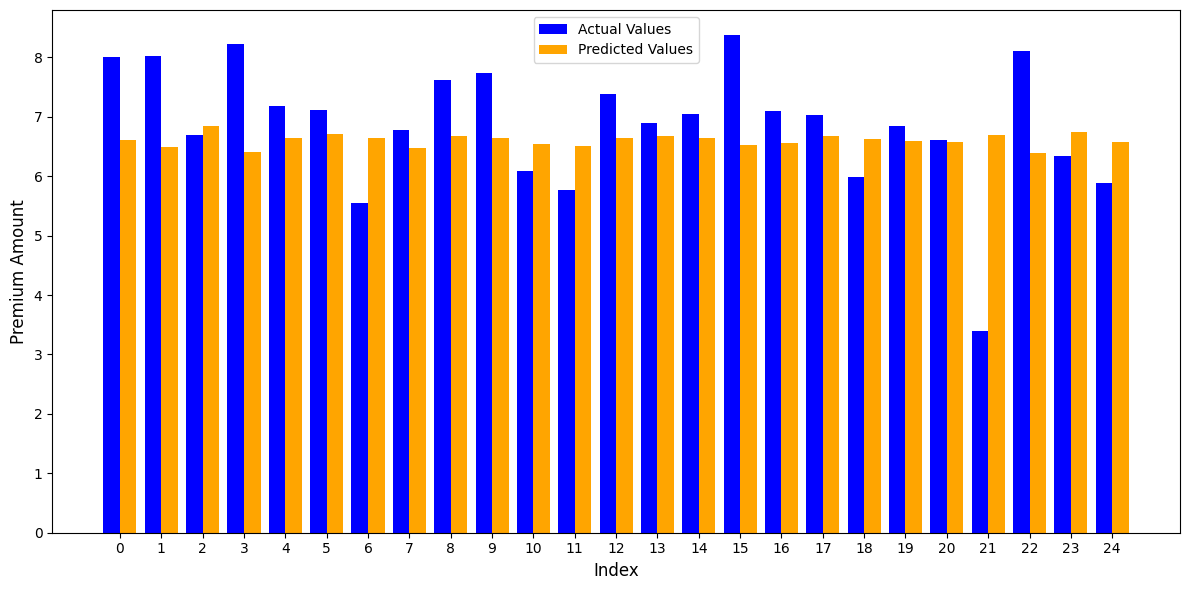

In [86]:
import matplotlib.pyplot as plt
import numpy as np

sample_indices = np.random.choice(len(y_test_final), 25, replace=False)
actuals = y_test_final.iloc[sample_indices].values
predictions = y_pred_final[sample_indices]
plt.figure(figsize=(12, 6))
x = np.arange(len(actuals))

plt.bar(x - 0.2, actuals, width=0.4, label='Actual Values', color='blue')
plt.bar(x + 0.2, predictions, width=0.4, label='Predicted Values', color='orange')

plt.xlabel('Index', fontsize=12)
plt.ylabel('Premium Amount', fontsize=12)
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
# trying another approach

import pandas as pd

train_df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv", index_col = 'id', engine='pyarrow').dropna(subset=['Premium Amount'])
test_df = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv", index_col = 'id', engine='pyarrow')
target = 'Premium Amount'

def date_separator(x):
    return pd.Series([x.day, x.month, x.year])

train_df[['day', 'month', 'year']] = train_df['Policy Start Date'].apply(date_separator)
test_df[['day', 'month', 'year']] = test_df['Policy Start Date'].apply(date_separator)

numerical_features = train_df.drop(target, axis=1).select_dtypes(include=np.number).columns.values
categorical_features = train_df.drop(target, axis=1).select_dtypes(include='object').columns.values

# train_df.duplicated().sum() == 0

In [20]:
train_df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1181295.0,41.145563,13.539950,18.000000,30.000000,41.000000,53.000000,64.000000
Annual Income,1155051.0,32745.217777,32179.506124,1.000000,8001.000000,23911.000000,44634.000000,149997.000000
Number of Dependents,1090328.0,2.009934,1.417338,0.000000,1.000000,2.000000,3.000000,4.000000
Health Score,1125924.0,25.613908,12.203462,2.012237,15.918959,24.578648,34.527209,58.975914
Previous Claims,835971.0,1.002689,0.982840,0.000000,0.000000,1.000000,2.000000,9.000000
Vehicle Age,1199994.0,9.569889,5.776189,0.000000,5.000000,10.000000,15.000000,19.000000
Credit Score,1062118.0,592.924350,149.981945,300.000000,468.000000,595.000000,721.000000,849.000000
Insurance Duration,1199999.0,5.018219,2.594331,1.000000,3.000000,5.000000,7.000000,9.000000
day,1200000.0,15.706179,8.811727,1.000000,8.000000,16.000000,23.000000,31.000000
month,1200000.0,6.492671,3.432689,1.000000,4.000000,6.000000,9.000000,12.000000


In [21]:
train_df[categorical_features].describe().T

,count,unique,top,freq
Gender,1200000,2,Male,602571
Marital Status,1181471,3,Single,395391
Education Level,1200000,4,Master's,303818
Occupation,841925,3,Employed,282750
Location,1200000,3,Suburban,401542
Policy Type,1200000,3,Premium,401846
Customer Feedback,1122176,3,Average,377905
Smoking Status,1200000,2,Yes,601873
Exercise Frequency,1200000,4,Weekly,306179
Property Type,1200000,3,House,400349


In [81]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import category_encoders

preprocessing = ColumnTransformer([
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numerical_features),
    ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder()), categorical_features)
], remainder='drop')

In [82]:
X = train_df.copy()
y = X.pop(target)
y = np.log1p(y)

In [83]:
X = preprocessing.fit_transform(X, y)
# testProcessed = preprocessing.transform(test_df)
display(X)

array([[-1.64847095e+00, -7.18893151e-01, -7.47535373e-01, ...,
         0.00000000e+00,  3.00000000e+00,  2.00000000e+00],
       [-1.59711382e-01, -3.38036742e-02,  7.32829857e-01, ...,
         1.00000000e+00,  1.00000000e+00,  2.00000000e+00],
       [-1.35071904e+00, -2.26258418e-01,  7.32829857e-01, ...,
         1.00000000e+00,  3.00000000e+00,  2.00000000e+00],
       ...,
       [-1.64847095e+00,  6.06212877e-01, -1.48771799e+00, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.03129627e+00,  2.30462897e-16, -7.47535373e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.49959499e+00,  2.30462897e-16, -1.48771799e+00, ...,
         1.00000000e+00,  1.00000000e+00,  2.00000000e+00]])

In [84]:
columns = numerical_features.tolist() + categorical_features.tolist()
X_df = pd.DataFrame(X, columns = columns)
display(X_df)
# train_df.info()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,day,month,...,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,-1.648471,-7.188932e-01,-0.747535,-0.255071,1.215746e+00,1.286338,-1.565702e+00,-0.007023,0.827741,1.604378,...,0.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,3.0,2.0
1,-0.159711,-3.380367e-02,0.732830,-0.849704,-3.278064e-03,0.420713,7.163281e-01,-1.163391,-0.420596,-0.143523,...,0.0,0.0,2.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0
2,-1.350719,-2.262584e-01,0.732830,1.824212,-3.278064e-03,0.766963,-1.611408e-15,-0.777935,1.622137,0.730427,...,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,2.0
3,-1.499595,3.456006e+00,-0.007353,-1.241521,-3.278064e-03,-1.656787,-1.601137e+00,-1.548847,-0.420596,-0.143523,...,1.0,1.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0
4,-1.499595,2.187377e-01,-0.747535,-0.443102,-1.222302e+00,-0.271787,3.597138e-02,-0.392479,-1.668933,1.604378,...,1.0,2.0,0.0,1.0,0.0,2.0,2.0,1.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,-0.383025,-1.719682e-01,-1.487718,-1.001709,-5.413556e-16,-0.791162,-1.565702e+00,-0.777935,-1.441963,-0.434840,...,0.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0
1199996,0.956858,9.631550e-02,0.000000,-1.195387,-5.413556e-16,0.074463,2.888433e-02,-0.392479,-0.647567,0.730427,...,1.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,3.0,0.0
1199997,-1.648471,6.062129e-01,-1.487718,-0.921210,-1.222302e+00,1.632588,-1.611408e-15,0.378433,1.054711,-0.434840,...,1.0,0.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0,1.0
1199998,1.031296,2.304629e-16,-0.747535,-0.597805,-3.278064e-03,-0.444912,-1.317655e+00,-0.392479,0.373800,0.730427,...,1.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0


In [85]:
import numpy as np

model = LinearRegression()
# model = XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.5,
#     max_depth=10,
#     random_state=1
# )
# X = train_df.copy()
# y = X.pop(target)
X = X_df
x_train_full, x_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=3
)
model.fit(x_train_full, y_train_full)
y_pred_final = model.predict(x_test_final)

mse = mean_squared_error(y_test_final, y_pred_final)
print(f"MSE = {mse}")

MSE = 1.1900542925145734
